In [1]:
import mysql.connector
from mysql.connector import errorcode
import xmltodict
import time
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Step 1. Get the users who have achieved badges where at least 100 users have achieved that badge

In [2]:
# Obtain connection string information from the portal
config = {
  'host': 'stack-overflow-db.mysql.database.azure.com',
  'user': 'stack-overflow@stack-overflow-db',
  'password': 'password1!',
  'database': 'stackoverflow'
}

file = '../data/df_silver_badge_users.pkl'

# read the cached resul if exists
if os.path.exists(file):
    df_silver_badge_users = pd.read_pickle(file)
else:
    # 1=Gold, 2=Silver, 3=Bronze
    badge_class = 2
    count_of_users = 100

    try:
        conn = mysql.connector.connect(**config)
        df_silver_badge_users = pd.read_sql_query(
            f'''
            SELECT b1.UserId, b1.Name, b1.Date FROM badges as b1
            INNER JOIN (
                  SELECT count(Id) as 'count', Name FROM badges
                  WHERE
                    Class={badge_class} AND TagBased = 1
                  GROUP BY Name
                  Having COUNT(Id) >= {count_of_users}
                ) b2
              ON (
                b1.Name = b2.Name AND
                b1.TagBased = 1 AND
                b1.Class = {badge_class}
              )
            GROUP BY b1.UserId, b1.Name, b1.Date;
            ''',
            con=conn)
    except mysql.connector.Error as err:
        if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
            print("Something is wrong with the user name or password")
        elif err.errno == errorcode.ER_BAD_DB_ERROR:
            print("Database does not exist")
        else:
            print(err)

    conn.close()
    # cache the result
    df_silver_badge_users.to_pickle(file)

In [3]:
print(df_silver_badge_users.shape)
print(len(df_silver_badge_users.UserId.unique()))
df_silver_badge_users.head()

(17013, 3)
10366


UserId   Name                Date
0      13      c 2010-12-24 03:01:38
1      13    c++ 2009-05-10 05:44:36
2      13   java 2009-10-12 06:51:24
3      13  linux 2015-01-16 03:09:37
4      17   .net 2013-08-08 03:03:50

Step 2. Find all of the posts from these users.

In [4]:
# read the cached resul if exists
file = '../data/df_silver_posts_all.pkl'

if os.path.exists(file):
    df_posts = pd.read_pickle(file)
else:    
    try:
        conn = mysql.connector.connect(**config)
        df_posts = pd.read_sql_query(
            f'''
            SELECT Id, PostTypeId, ParentId, CreationDate, Score, OwnerUserId, Tags FROM posts
            WHERE 
                OwnerUserId in ({','.join([str(id) for id in np.random.choice(df_silver_badge_users.UserId.unique(), size=250, replace=False)])})
            ''',
            con=conn)
    except mysql.connector.Error as err:
        if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
            print("Something is wrong with the user name or password")
        elif err.errno == errorcode.ER_BAD_DB_ERROR:
            print("Database does not exist")
        else:
            print(err)
    conn.close()
    df_posts.to_pickle(file)

In [5]:
print(df_posts.shape)
df_posts.head()

(221203, 7)


Id  PostTypeId  ParentId        CreationDate  Score  OwnerUserId  \
0  10280           2     10274 2008-08-13 19:27:43      1         1143   
1  10309           1         0 2008-08-13 19:56:53      6         1143   
2  10362           2     10349 2008-08-13 20:52:21      2         1143   
3  10878           2     10872 2008-08-14 10:42:36      5         1143   
4  20142           2       482 2008-08-21 14:48:34     20         1143   

                              Tags  
0                                   
1  <compact-framework><windows-ce>  
2                                   
3                                   
4

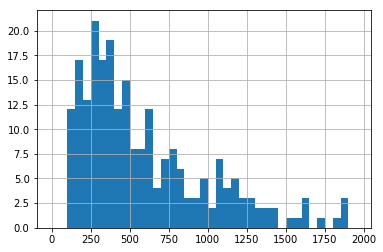

In [6]:
fig, ax = plt.subplots(1,1)
df_posts.groupby(['OwnerUserId']).agg('count').Id.hist(ax=ax, bins=np.arange(0,2000,50))
# ax.set_xlim([0,1000])
plt.show()

Step 3. Case Study. Get 250 users who obtained the python badge. Get only their answers but get the tags of the questions that were asked

In [8]:
# read the cached resul if exists
file = '../data/df_silver_posts_python_answers.pkl'
python_users = ','.join([str(id) for id in np.random.choice(df_silver_badge_users[df_silver_badge_users.Name == 'python'].UserId.unique(), size=1000, replace=False)])

if os.path.exists(file):
    df_p_posts = pd.read_pickle(file)
else:    
    try:
        conn = mysql.connector.connect(**config)
        df_p_posts = pd.read_sql_query(
            f'''
            SELECT answers.Id, answers.PostTypeId,
                   answers.CreationDate, answers.Score,
                   answers.OwnerUserId, answers.ParentId, questions.tags
            FROM posts as answers
            INNER JOIN Posts as questions ON (
                answers.OwnerUserId in ({python_users}) and 
                answers.PostTypeId = 2 and
                questions.Id = answers.ParentId)
            ''',
            con=conn)
    except mysql.connector.Error as err:
        if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
            print("Something is wrong with the user name or password")
        elif err.errno == errorcode.ER_BAD_DB_ERROR:
            print("Database does not exist")
        else:
            print(err)
    conn.close()
    df_p_posts.to_pickle(file)

In [9]:
df_p_posts['python'] = df_p_posts.tags.str.contains('python')
df_p_posts.head()

Id  PostTypeId        CreationDate  Score  OwnerUserId  ParentId  \
0   635           2 2008-08-03 08:34:57      4          188       337   
1  1191           2 2008-08-04 12:41:16      2          188      1171   
2  2051           2 2008-08-05 10:00:47      5          188      2027   
3  2054           2 2008-08-05 10:05:07      2          188      2048   
4  2979           2 2008-08-06 00:26:27      7          188      2898   

                                                tags  python  
0                                      <python><xml>    True  
1  <python><performance><data-structures><graph-t...    True  
2  <language-agnostic><oop><parameters><pass-by-r...   False  
3                                              <rss>   False  
4                                    <linux><editor>   False

step 4. Get a totally different action type that is still quite common

In [10]:
# read the cached resul if exists
file = '../data/df_silver_comments_python.pkl'
python_users = ','.join([str(int(i)) for i in df_p_posts.OwnerUserId.unique()])

if os.path.exists(file):
    df_p_comments = pd.read_pickle(file)
else:    
    try:
        conn = mysql.connector.connect(**config)
        df_p_comments = pd.read_sql_query(
            f'''
            SELECT c.Id, c.PostId,
                   c.CreationDate, c.Score,
                   c.UserId, questions.tags
            FROM comments as c
            INNER JOIN Posts as questions ON (
                c.UserId in ({python_users}) AND 
                questions.PostTypeId = 1 AND
                questions.Id = c.PostId);
            ''',
            con=conn)
    except mysql.connector.Error as err:
        if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
            print("Something is wrong with the user name or password")
        elif err.errno == errorcode.ER_BAD_DB_ERROR:
            print("Database does not exist")
        else:
            print(err)
    conn.close()
    df_p_comments.to_pickle(file)

In [11]:
print(df_p_comments.shape)
df_p_comments['python'] = df_p_comments.tags.str.contains('python')
df_p_comments.head()

(1496437, 6)


Id  PostId        CreationDate  Score  UserId  \
0   69647  190544 2008-10-10 08:45:22      0     188   
1  144284  297636 2008-11-18 04:16:54      0     188   
2  144714  270879 2008-11-18 11:43:56      0     188   
3  155027  305359 2008-11-23 11:14:31      0     188   
4  187639  356090 2008-12-10 14:05:57      5     188   

                         tags  python  
0                 <algorithm>   False  
1                   <browser>   False  
2   <python><orm><sqlalchemy>    True  
3  <python><types><sequences>    True  
4    <python><math><nth-root>    True

In [12]:
file = '../data/df_silver_users_python.pkl'
python_users = ','.join([str(int(i)) for i in df_p_posts.OwnerUserId.unique()])

if os.path.exists(file):
    df_p_users = pd.read_pickle(file)
else:    
    try:
        conn = mysql.connector.connect(**config)
        df_p_users = pd.read_sql_query(
            f'''
            SELECT u.Id, u.Reputation, u.CreationDate, u.LastAccessDate
            FROM users as u
            WHERE u.Id in ({python_users});
            ''',
            con=conn)
    except mysql.connector.Error as err:
        if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
            print("Something is wrong with the user name or password")
        elif err.errno == errorcode.ER_BAD_DB_ERROR:
            print("Database does not exist")
        else:
            print(err)
    conn.close()
    df_p_users.to_pickle(file)

In [13]:
df_p_users.head()

Id  Reputation        CreationDate      LastAccessDate
0   188       26866 2008-08-03 08:34:57 2018-11-29 02:30:16
1   476      388495 2008-08-06 08:15:28 2018-12-01 18:26:25
2  1114           1 2008-08-12 12:54:43 2018-12-01 14:01:20
3  1694      117539 2008-08-18 02:45:22 2018-11-29 20:38:01
4  1897       43103 2008-08-19 07:54:50 2018-12-02 03:33:04

In [59]:
file = '../data/df_silver_users_other_badges.pkl'
python_users = ','.join([str(int(i)) for i in df_p_posts.OwnerUserId.unique()])

if os.path.exists(file):
    df_p_badges = pd.read_pickle(file)
else:    
    try:
        conn = mysql.connector.connect(**config)
        df_p_badges = pd.read_sql_query(
            f'''
            SELECT b.Id, b.UserId, b.Name, b.Date, b.Class, b.TagBased
            FROM badges as b
            WHERE b.UserId in ({python_users});
            ''',
            con=conn)
    except mysql.connector.Error as err:
        if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
            print("Something is wrong with the user name or password")
        elif err.errno == errorcode.ER_BAD_DB_ERROR:
            print("Database does not exist")
        else:
            print(err)
    conn.close()
    df_p_badges.to_pickle(file)

### Questions to investigate:

1) Distributions of questions and answers?

2) Distributions of tag topics for questions and answers?

3) Distributions of Questions and Answers over time (are these drawn from the same distribution)?

4) Are there tags that commonly occur together?

5) Can we quantify the 'causal effect' of the badge on these users?

6) Does the distribution over actions change 'close' to the badge boundary and what defines 'close' in this case?

# (1)

(0, 2000)

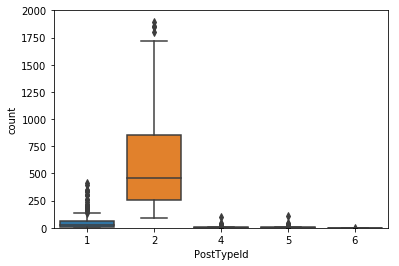

In [14]:
fig, ax = plt.subplots(1,1)
sns.boxplot(data=df_posts.groupby(['OwnerUserId', 'PostTypeId']).size().reset_index(name='count'),
            x='PostTypeId', y='count', ax=ax)
ax.set_ylim([0,2000])

Insight: people answer many more posts than they ask...

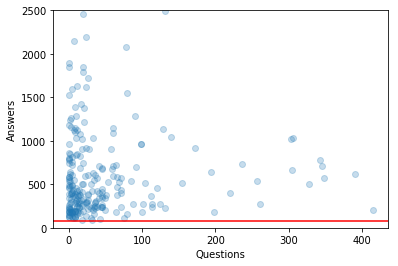

In [15]:
df = df_posts.groupby(['OwnerUserId', 'PostTypeId']).size().reset_index(name='count')
# df.pivot('OwnerUserId')
x,y = df.pivot(index='OwnerUserId', columns='PostTypeId', values='count').loc[:,1:3].fillna(0).values.T

plt.scatter(x, y, alpha=.25)
plt.ylabel('Answers')
plt.xlabel('Questions')
plt.ylim([0,2500])
plt.axhline(y=80, c='r')
plt.show()

In [16]:
df_p_posts.head()

Id  PostTypeId        CreationDate  Score  OwnerUserId  ParentId  \
0   635           2 2008-08-03 08:34:57      4          188       337   
1  1191           2 2008-08-04 12:41:16      2          188      1171   
2  2051           2 2008-08-05 10:00:47      5          188      2027   
3  2054           2 2008-08-05 10:05:07      2          188      2048   
4  2979           2 2008-08-06 00:26:27      7          188      2898   

                                                tags  python  
0                                      <python><xml>    True  
1  <python><performance><data-structures><graph-t...    True  
2  <language-agnostic><oop><parameters><pass-by-r...   False  
3                                              <rss>   False  
4                                    <linux><editor>   False

(0, 2000)

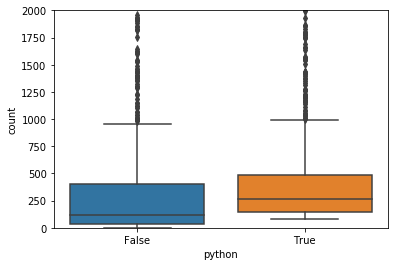

In [17]:
fig, ax = plt.subplots(1,1)
sns.boxplot(data=df_p_posts.groupby(['OwnerUserId', 'python']).size().reset_index(name='count'),
            x='python', y='count', ax=ax)
ax.set_ylim([0,2000])

In [18]:
df_p_comments.head()

Id  PostId        CreationDate  Score  UserId  \
0   69647  190544 2008-10-10 08:45:22      0     188   
1  144284  297636 2008-11-18 04:16:54      0     188   
2  144714  270879 2008-11-18 11:43:56      0     188   
3  155027  305359 2008-11-23 11:14:31      0     188   
4  187639  356090 2008-12-10 14:05:57      5     188   

                         tags  python  
0                 <algorithm>   False  
1                   <browser>   False  
2   <python><orm><sqlalchemy>    True  
3  <python><types><sequences>    True  
4    <python><math><nth-root>    True

(0, 2000)

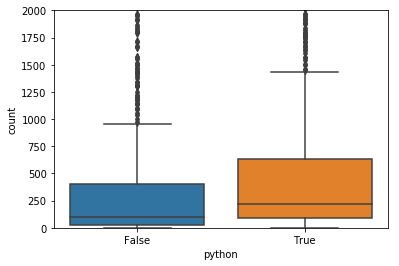

In [19]:
fig, ax = plt.subplots(1,1)
sns.boxplot(data=df_p_comments.groupby(['UserId', 'python']).size().reset_index(name='count'),
            x='python', y='count', ax=ax)
ax.set_ylim([0,2000])

# (2)

In [20]:
df = pd.merge(df_p_posts, df_silver_badge_users, left_on='OwnerUserId', right_on='UserId', how='inner')
df['days_from_badge'] = df.apply(lambda row: (row.CreationDate - row.Date).days//14, axis=1)
df.head()

Id  PostTypeId        CreationDate  Score  OwnerUserId  ParentId  \
0   635           2 2008-08-03 08:34:57      4          188       337   
1   635           2 2008-08-03 08:34:57      4          188       337   
2  1191           2 2008-08-04 12:41:16      2          188      1171   
3  1191           2 2008-08-04 12:41:16      2          188      1171   
4  2051           2 2008-08-05 10:00:47      5          188      2027   

                                                tags  python  UserId    Name  \
0                                      <python><xml>    True     188  django   
1                                      <python><xml>    True     188  python   
2  <python><performance><data-structures><graph-t...    True     188  django   
3  <python><performance><data-structures><graph-t...    True     188  python   
4  <language-agnostic><oop><parameters><pass-by-r...   False     188  django   

                 Date  days_from_badge  
0 2017-08-10 04:04:37             -236  
1 2013-03-31 03:05:55             -122  
2 2017-08-10 04:04:37             -236  
3 2013-03-31 03:05:55             -122  
4 2017-08-10 04:04:37             -236

In [21]:
min_days = np.abs(df.days_from_badge.min())

design_matrix_true = np.zeros(shape=(len(df.UserId.unique()), df.days_from_badge.max() + min_days + 1))
design_matrix_false = np.zeros(shape=(len(df.UserId.unique()), df.days_from_badge.max() + min_days + 1))

design_matrix = [design_matrix_false, design_matrix_true]

last_max = 0
user_dict = {}

for (python, user_ix), user in df.groupby(['python', 'UserId']):

    if user_ix not in user_dict:
        user_dict[user_ix] = last_max
        last_max += 1
        
    for i, row in user.groupby('days_from_badge').size().reset_index(name='count').iterrows():
            design_matrix[1*python][user_dict[user_ix], min_days+row['days_from_badge']] = row['count']
         

In [22]:
design_matrix_true

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

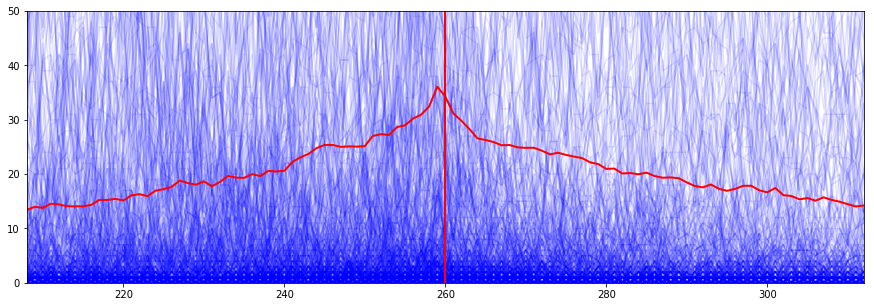

In [23]:
plt.figure(figsize=(15,5))
plt.plot(design_matrix[0].T, c='b', alpha=.1)
plt.plot(np.mean(design_matrix[0].T, axis=1), c='r', lw=2)
plt.xlim([min_days-52, min_days+52])
plt.ylim([0,50])
plt.axvline(x=min_days, c='r', lw=2)
plt.show()

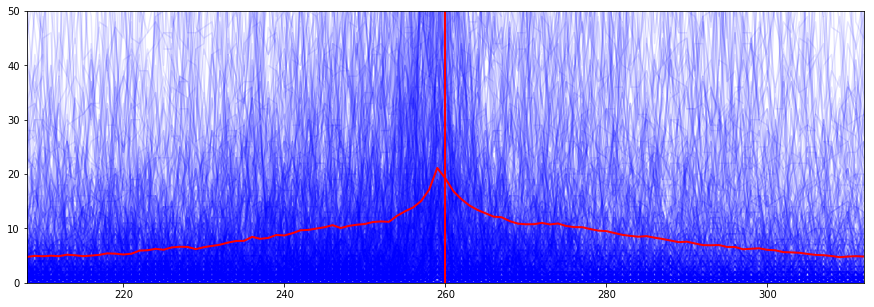

In [24]:
plt.figure(figsize=(15,5))
plt.plot(design_matrix[1].T, c='b', alpha=.1)
plt.plot(np.mean(design_matrix[1].T, axis=1), c='r', lw=2)
plt.xlim([min_days-52, min_days+52])
plt.ylim([0,50])
plt.axvline(x=min_days, c='r', lw=2)
plt.show()

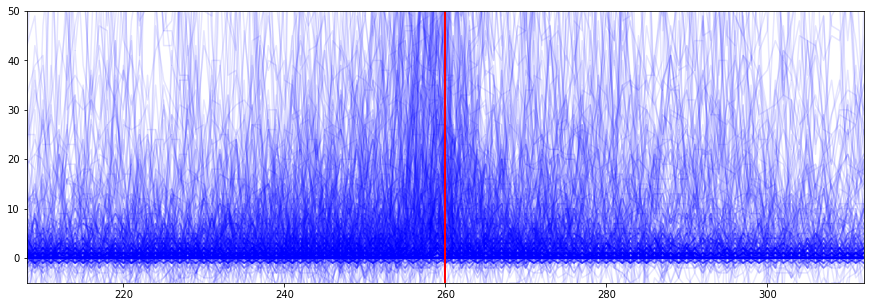

In [25]:
plt.figure(figsize=(15,5))
interested = design_matrix[1].T-design_matrix[0].T
plt.plot(interested[:, interested.sum(axis=0) > 0], c='b', alpha=.1)
plt.ylim([-5,50])
plt.xlim([min_days-52, min_days+52])
plt.axvline(x=min_days, c='r', lw=2)
plt.show()

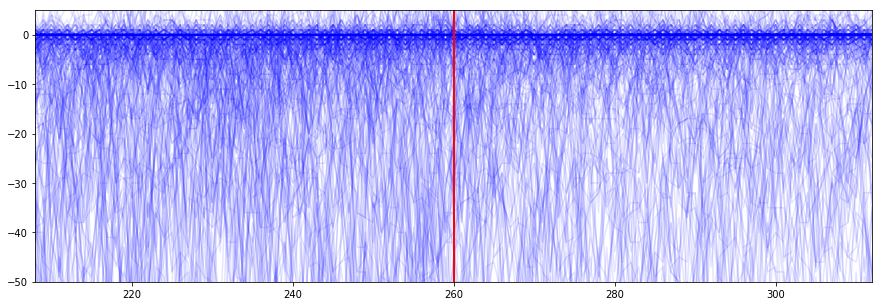

In [26]:
plt.figure(figsize=(15,5))
interested = design_matrix[1].T-design_matrix[0].T
plt.plot(interested[:, interested.sum(axis=0) < 0], c='b', alpha=.1)
plt.ylim([-50,5])
plt.xlim([min_days-52, min_days+52])
plt.axvline(x=min_days, c='r', lw=2)
plt.show()

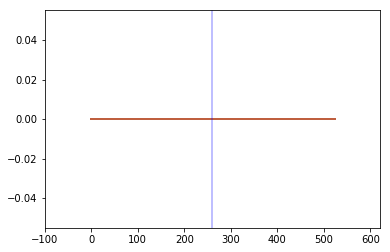

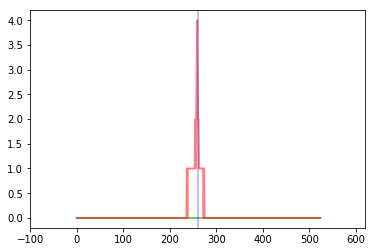

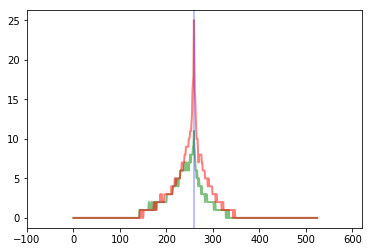

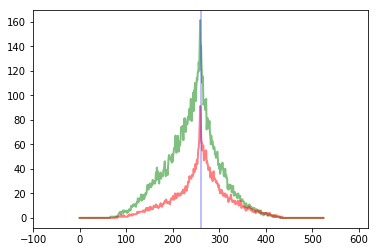

In [27]:
plt.plot(np.percentile(design_matrix[0].T, 20, axis=1), c='g', lw=2, alpha=.5)
plt.plot(np.percentile(design_matrix[1].T, 20, axis=1), c='r', lw=2, alpha=.5)
plt.xlim([min_days-360, min_days+360])
plt.axvline(x=min_days, c='b', lw=2, alpha=.25)
plt.show()


plt.plot(np.percentile(design_matrix[0].T, 50, axis=1), c='g', lw=2, alpha=.5)
plt.plot(np.percentile(design_matrix[1].T, 50, axis=1), c='r', lw=2, alpha=.5)
plt.xlim([min_days-360, min_days+360])
plt.axvline(x=min_days, c='b', lw=2, alpha=.25)
plt.show()

plt.plot(np.percentile(design_matrix[0].T, 80, axis=1), c='g', lw=2, alpha=.5)
plt.plot(np.percentile(design_matrix[1].T, 80, axis=1), c='r', lw=2, alpha=.5)
plt.xlim([min_days-360, min_days+360])
plt.axvline(x=min_days, c='b', lw=2, alpha=.25)
plt.show()

plt.plot(np.percentile(design_matrix[0].T, 95, axis=1), c='g', lw=2, alpha=.5)
plt.plot(np.percentile(design_matrix[1].T, 95, axis=1), c='r', lw=2, alpha=.5)
plt.xlim([min_days-360, min_days+360])
plt.axvline(x=min_days, c='b', lw=2, alpha=.25)
plt.show()


In [28]:
min_days = np.abs(df.days_from_badge.min())

design_matrix = np.zeros(shape=(len(df.UserId.unique()), df.days_from_badge.max() + min_days + 1))
last_max = 0
user_dict = {}

for u, user in df.groupby('UserId'):
    
    if u not in user_dict:
        user_dict[u] = last_max
        last_max += 1
        
    for d, day_group in user.groupby('days_from_badge'):
        py_posts = np.sum(day_group.python == True)
        not_py_posts = np.sum(day_group.python == False)
        
        design_matrix[user_dict[u], min_days+d] = py_posts/(py_posts+not_py_posts)

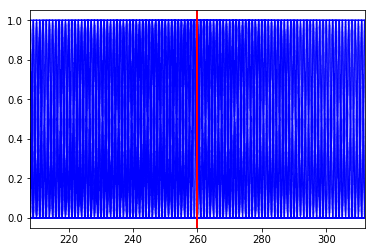

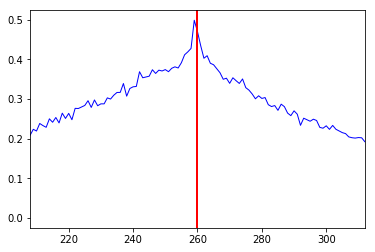

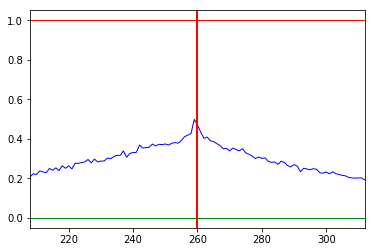

In [29]:
plt.plot(design_matrix.T, c='b', lw=1, alpha=.05)
plt.xlim([min_days-52, min_days+52])
plt.axvline(x=min_days, c='r', lw=2, alpha=1)
plt.show()


plt.plot(np.mean(design_matrix.T, axis=1), c='b', lw=1, alpha=1)
plt.xlim([min_days-52, min_days+52])
plt.axvline(x=min_days, c='r', lw=2, alpha=1)
plt.show()

plt.plot(np.percentile(design_matrix.T, 5, axis=1), c='green', lw=1, alpha=1)
plt.plot(np.percentile(design_matrix.T, 95, axis=1), c='red', lw=1, alpha=1)
plt.plot(np.mean(design_matrix.T, axis=1), c='b', lw=1, alpha=1)
plt.xlim([min_days-52, min_days+52])
plt.axvline(x=min_days, c='r', lw=2, alpha=1)
plt.show()

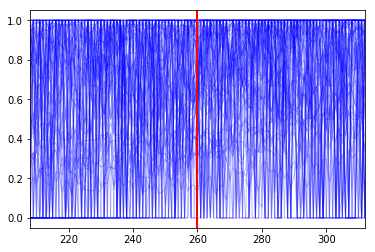

In [30]:
plt.plot(design_matrix.T[:,np.where(np.abs(design_matrix.mean(axis=1)-.5)<.25)[0]], c='b', lw=1, alpha=.25)
plt.xlim([min_days-52, min_days+52])
plt.axvline(x=min_days, c='r', lw=2, alpha=1)
plt.show()

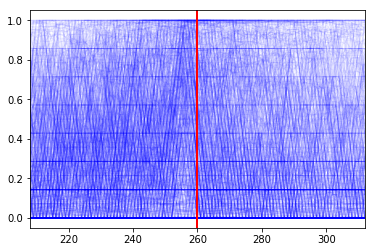

In [31]:
design_matrix.T.shape
N=7
vals = np.array([np.convolve(row, np.ones((N,))/N, mode='valid') for row in design_matrix])
plt.plot(vals.T, c='b', lw=1, alpha=.05)
plt.xlim([min_days-52, min_days+52])
plt.axvline(x=min_days, c='r', lw=2, alpha=1)
plt.show()

# (2a) Can we visualise the change (if any) in distribution of action types leading into the badge boundary?

In [75]:
df_p_comments['post_or_comment'] = 0
df_p_comments.head()

Id  PostId        CreationDate  Score  UserId  \
0   69647  190544 2008-10-10 08:45:22      0     188   
1  144284  297636 2008-11-18 04:16:54      0     188   
2  144714  270879 2008-11-18 11:43:56      0     188   
3  155027  305359 2008-11-23 11:14:31      0     188   
4  187639  356090 2008-12-10 14:05:57      5     188   

                         tags  python  post_or_comment  
0                 <algorithm>   False                0  
1                   <browser>   False                0  
2   <python><orm><sqlalchemy>    True                0  
3  <python><types><sequences>    True                0  
4    <python><math><nth-root>    True                0

In [76]:
df_p_posts.rename(columns={'OwnerUserId': 'UserId'}, inplace=True)
df_p_posts['post_or_comment'] = 1
df_p_posts.head()

Id  PostTypeId        CreationDate  Score  UserId  ParentId  \
0   635           2 2008-08-03 08:34:57      4     188       337   
1  1191           2 2008-08-04 12:41:16      2     188      1171   
2  2051           2 2008-08-05 10:00:47      5     188      2027   
3  2054           2 2008-08-05 10:05:07      2     188      2048   
4  2979           2 2008-08-06 00:26:27      7     188      2898   

                                                tags  python  post_or_comment  
0                                      <python><xml>    True                1  
1  <python><performance><data-structures><graph-t...    True                1  
2  <language-agnostic><oop><parameters><pass-by-r...   False                1  
3                                              <rss>   False                1  
4                                    <linux><editor>   False                1

In [77]:
cols = ['Id','CreationDate','UserId','tags','python','post_or_comment']
df = pd.concat([df_p_comments[df_p_comments.python==True][cols], df_p_posts[df_p_posts.python==False][cols]])
df.head()

Id        CreationDate  UserId                        tags  python  \
2  144714 2008-11-18 11:43:56     188   <python><orm><sqlalchemy>    True   
3  155027 2008-11-23 11:14:31     188  <python><types><sequences>    True   
4  187639 2008-12-10 14:05:57     188    <python><math><nth-root>    True   
5  187642 2008-12-10 14:06:37     188    <python><math><nth-root>    True   
7  323752 2009-02-03 23:40:57     188     <python><file><newline>    True   

   post_or_comment  
2                0  
3                0  
4                0  
5                0  
7                0

In [102]:
time_ = 500
user_matrix = np.zeros(shape=(len(df.UserId.unique()), time_*2))
users_badges = df_silver_badge_users.set_index(['UserId', 'Name'])
i = 0

for u,user in df.groupby('UserId'):

    user.sort_values('CreationDate', inplace=True)
    badge_date = users_badges.loc[u,'python'].Date
    count_before_badge = user[user.CreationDate <= badge_date].shape[0]
    count_after_badge = user[user.CreationDate > badge_date].shape[0]
    index = np.arange(-count_before_badge, count_after_badge)
    user.set_index(index, inplace=True)

    action = user.loc[-time_:time_-1].post_or_comment.values
    index = user.loc[-time_:time_-1].index

    user_matrix[i][index + time_] = action+1
    i+=1

/home/nick/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


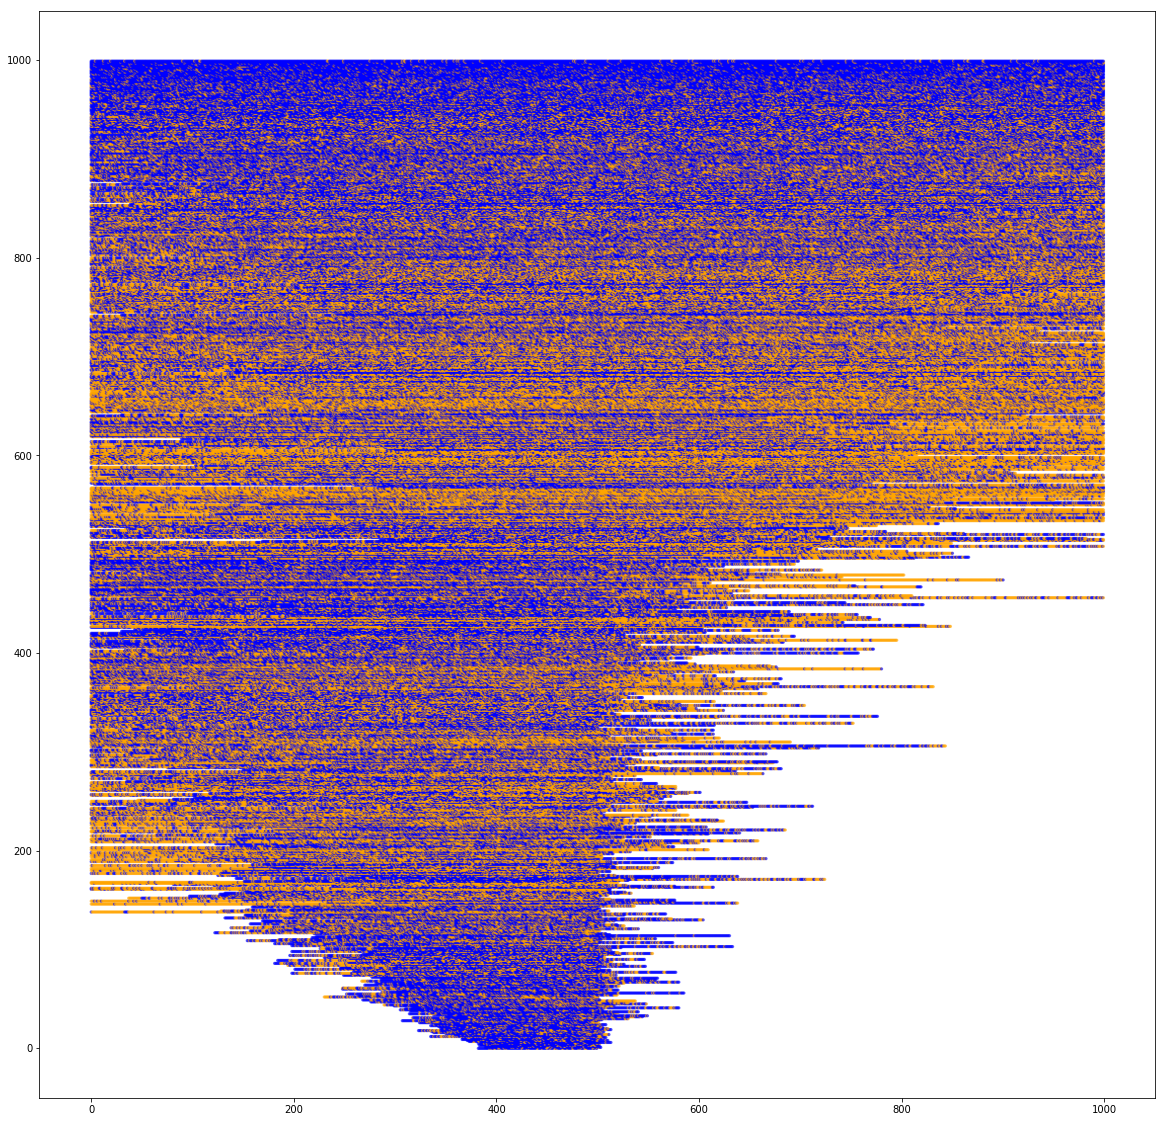

In [105]:
plt.figure(figsize=(20,20))

order = np.argsort(user_matrix.sum(axis=1))
for i, user in enumerate(user_matrix[order]):
    
    y = np.ones_like(user)*i
    x = np.arange(0,len(user))
    x = x[user!=0]
    y = y[user!=0]
    c = ['orange' if a == 1 else 'blue' for a in user[user!=0]]
    
    plt.scatter(x, y, c=c, alpha=.5, s=5)
# plt.axvline(x=time_, c='red', lw=2)
plt.show()

In [106]:
df = pd.concat([df_p_comments[cols], df_p_posts[cols]])

time_ = 500
user_matrix = np.zeros(shape=(len(df.UserId.unique()), time_*2))
users_badges = df_silver_badge_users.set_index(['UserId', 'Name'])
i = 0

for u,user in df.groupby('UserId'):

    user.sort_values('CreationDate', inplace=True)
    badge_date = users_badges.loc[u,'python'].Date
    count_before_badge = user[user.CreationDate <= badge_date].shape[0]
    count_after_badge = user[user.CreationDate > badge_date].shape[0]
    index = np.arange(-count_before_badge, count_after_badge)
    user.set_index(index, inplace=True)

    
    action = user.loc[-time_:time_-1].python.values*2
    action += user.loc[-time_:time_-1].post_or_comment
    index = user.loc[-time_:time_-1].index

    user_matrix[i][index + time_] = action+1
    i+=1
    

/home/nick/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


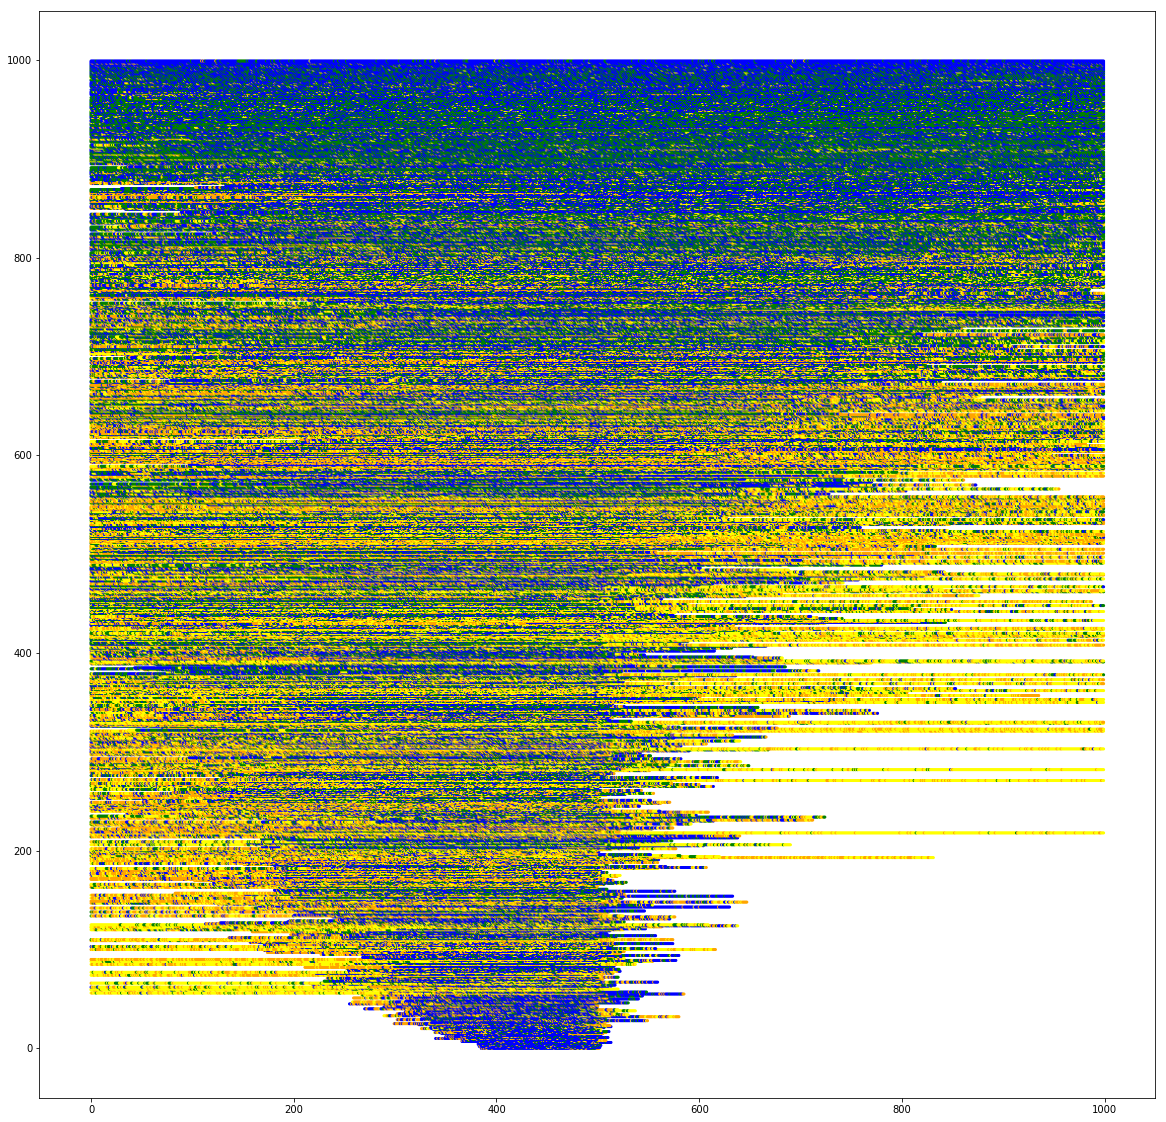

In [107]:
plt.figure(figsize=(20,20))

order = np.argsort(user_matrix.sum(axis=1))
cmap = {1: 'yellow', 2: 'orange', 3:'green', 4:'blue'}

for i, user in enumerate(user_matrix[order]):
    
    y = np.ones_like(user)*i
    x = np.arange(0,len(user))
    x = x[user!=0]
    y = y[user!=0]
    c = [cmap[a] for a in user[user!=0]]
    
    plt.scatter(x, y, c=c, alpha=1, s=4)


#     plt.axvline(x=time_, c='red', lw=2)
plt.show()

[]

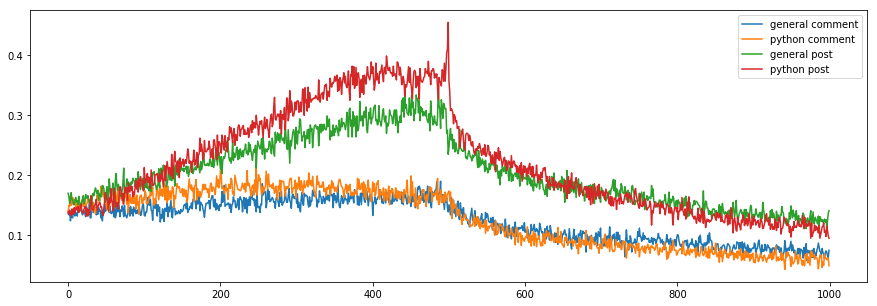

In [108]:
disengagement = (user_matrix == 0).mean(axis=0)

average_number_comments_not_python = (user_matrix == 1).mean(axis=0)
average_number_comments_python = (user_matrix == 2).mean(axis=0)
average_number_posts_not_python = (user_matrix == 3).mean(axis=0)
average_number_posts_python = (user_matrix == 4).mean(axis=0)


plt.figure(figsize=(15,5))
plt.plot(average_number_comments_not_python, label='general comment')
plt.plot(average_number_comments_python, label='python comment')
plt.plot(average_number_posts_not_python, label='general post')
plt.plot(average_number_posts_python, label='python post')

plt.legend(loc='best')
plt.plot()

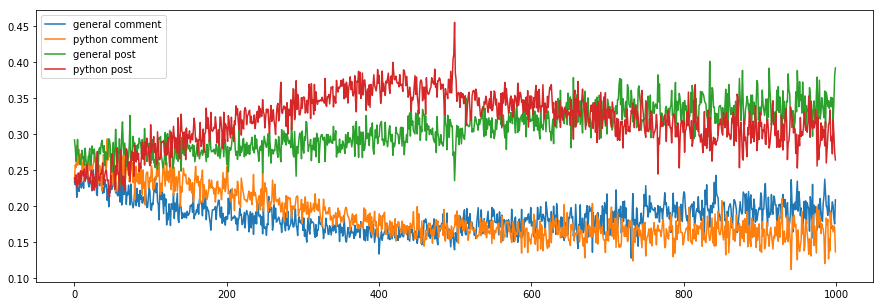

In [109]:
statistics = []
for feature in [1,2,3,4]:
    
    m = []
    for slice_ in user_matrix.T:
        vals = slice_[slice_ != 0]
        m.append((vals == feature).mean())
    
    statistics.append(m)
    
plt.figure(figsize=(15,5))
labels = ['general comment', 'python comment', 'general post', 'python post']
for i, s in enumerate(statistics):
    plt.plot(s, label=labels[i])
plt.legend(loc='best')
plt.show()


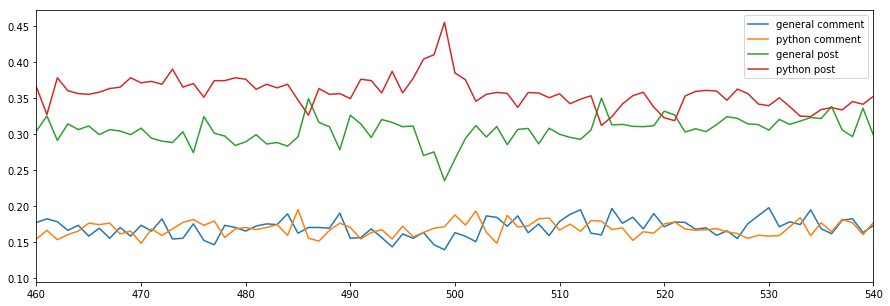

In [110]:
statistics = []
for feature in [1,2,3,4]:
    
    m = []
    for slice_ in user_matrix.T:
        vals = slice_[slice_ != 0]
        m.append((vals == feature).mean())
    
    statistics.append(m)
    
plt.figure(figsize=(15,5))
labels = ['general comment', 'python comment', 'general post', 'python post']
for i, s in enumerate(statistics):
    plt.plot(s, label=labels[i])
plt.xlim([460,540])
plt.legend(loc='best')
plt.show()

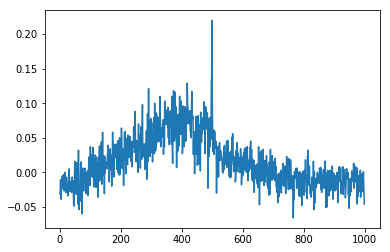

In [111]:
plt.plot(average_number_posts_python - average_number_posts_not_python)

What are the most commonly occuring other badges in our user group

In [42]:
python_users = df.UserId.unique()
badges_for_python_users = df_silver_badge_users[df_silver_badge_users.UserId.isin(python_users)]

counts = badges_for_python_users.groupby('Name').size().reset_index(name='count')
counts.sort_values('count')

Name  count
2       angularjs      1
36            wpf      2
5     asp.net-mvc      2
16            ios      3
31  ruby-on-rails      4
32          scala      4
17         iphone      4
4         asp.net      5
23        node.js      6
34     sql-server      7
1         android      7
10          c++11      7
14        haskell      8
25           perl      9
11            css     11
24    objective-c     11
30           ruby     13
28              r     14
0            .net     14
13            git     16
20         jquery     19
15           html     20
33            sql     23
22          mysql     28
8              c#     34
6            bash     35
21          linux     40
26            php     48
3          arrays     51
29          regex     51
35         string     59
19     javascript     60
7               c     67
18           java     69
9             c++     74
12         django     76
27         python   1000

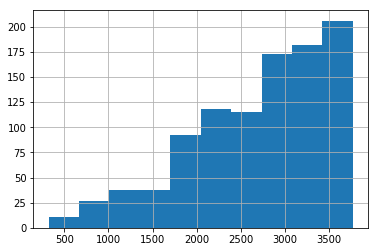

In [50]:
df_p_users.apply(lambda x: (x.LastAccessDate - x.CreationDate).days, axis=1).hist()

# (3)

In [96]:
df_min_interaction = df_posts.groupby('OwnerUserId').agg('min')[['CreationDate']].reset_index()
df_min_interaction.rename(columns={'CreationDate': 'date_of_first_post'}, inplace=True)
df = pd.merge(df_posts, df_min_interaction, on='OwnerUserId', how='inner')
df['days'] = df.apply(lambda row: (row.CreationDate - row.date_of_first_post).days, axis=1)

In [97]:
df.head()

Id  PostTypeId  ParentId        CreationDate  Score  OwnerUserId  \
0  10280           2     10274 2008-08-13 19:27:43      1         1143   
1  10309           1         0 2008-08-13 19:56:53      6         1143   
2  10362           2     10349 2008-08-13 20:52:21      2         1143   
3  10878           2     10872 2008-08-14 10:42:36      5         1143   
4  20142           2       482 2008-08-21 14:48:34     20         1143   

                              Tags  date_of_first_post  days  
0                                  2008-08-13 19:27:43     0  
1  <compact-framework><windows-ce> 2008-08-13 19:27:43     0  
2                                  2008-08-13 19:27:43     0  
3                                  2008-08-13 19:27:43     0  
4                                  2008-08-13 19:27:43     7

In [114]:
def plot_interaction_data(df_in, ax, post_type_id=1, color='b', alpha=.5):
    df = df_in[df_in.PostTypeId == post_type_id]
    design_matrix = np.zeros(shape=(len(df.OwnerUserId.unique()), df.days.max() - df.days.min() + 1))
    
    u = 0
    for ix, user in df.groupby('OwnerUserId'):
        
        for i, row in user.groupby('days').size().reset_index(name='count').iterrows():
            design_matrix[u, row['days']] = row['count']
        
        u += 1
    ax.plot(design_matrix.T, c=color, alpha=alpha)
    ax.plot(np.mean(design_matrix, axis=0), lw=2, c='r')
    
    return ax

Text(0.5, 1.0, 'Answers in First 2 years')

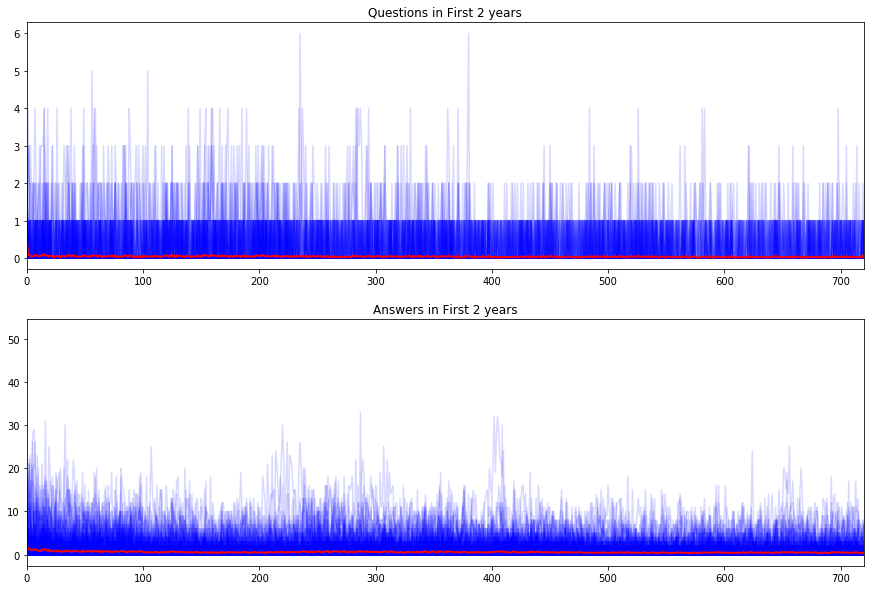

In [115]:
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(15,10))

ax1.set_xlim([0,720])
plot_interaction_data(df, ax1, post_type_id=1, color='b', alpha=.15)

ax2.set_xlim([0,720])
plot_interaction_data(df, ax2, post_type_id=2, color='b', alpha=.15)

ax1.set_title('Questions in First 2 years')
ax2.set_title('Answers in First 2 years')

Have a look around the receipt of the users FIRST badge.

In [135]:
df_min_interaction = df_silver_badge_users.groupby('UserId').agg('min')[['Date']].reset_index()
df_min_interaction.rename(columns={'Date': 'date_of_first_badge'}, inplace=True)
df = pd.merge(df_posts, df_min_interaction, left_on='OwnerUserId', right_on='UserId', how='inner')
df['days'] = df.apply(lambda row: (row.CreationDate - row.date_of_first_badge).days, axis=1)

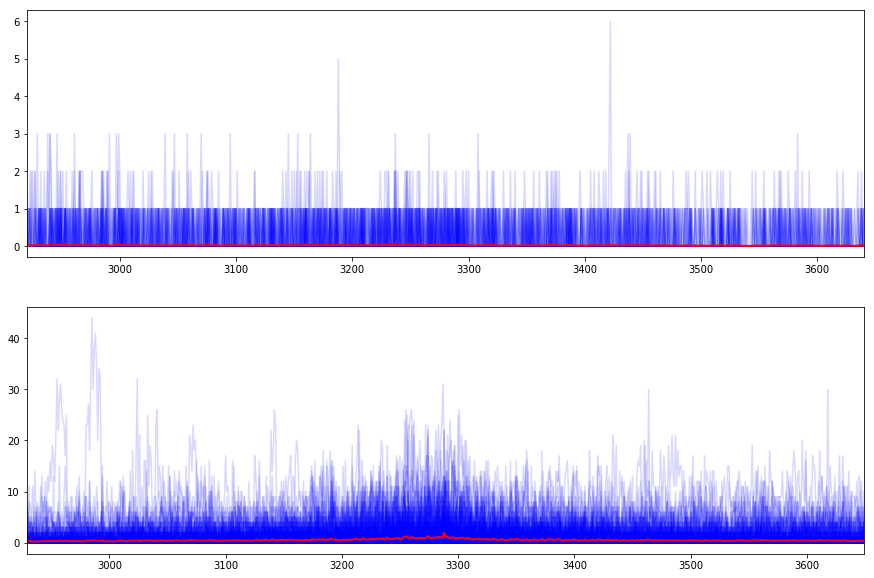

In [136]:
def plot_interaction_data(df_in, ax, post_type_id=1, color='b', alpha=.5):
    df = df_in[df_in.PostTypeId == post_type_id]
    
    days_min = np.abs(df.days.min())
    design_matrix = np.zeros(shape=(len(df.OwnerUserId.unique()), df.days.max()+days_min+1))
    
    u = 0
    for ix, user in df.groupby('OwnerUserId'):
        
        for i, row in user.groupby('days').size().reset_index(name='count').iterrows():
            design_matrix[u, days_min + row['days']] = row['count']
        
        u += 1
    ax.plot(design_matrix.T, c=color, alpha=alpha)
    ax.plot(np.mean(design_matrix, axis=0), lw=2, c='r')
    
    return ax, days_min

fig, (ax1,ax2) = plt.subplots(2,1, figsize=(15,10))

lim = 360
_, days_min = plot_interaction_data(df, ax1, post_type_id=1, color='b', alpha=.15)
ax1.set_xlim([days_min-lim, days_min+lim])

_, days_min = plot_interaction_data(df, ax2, post_type_id=2, color='b', alpha=.15)
ax2.set_xlim([days_min-lim, days_min+lim])

plt.show()

Have a look around the receipt of the users LAST badge.

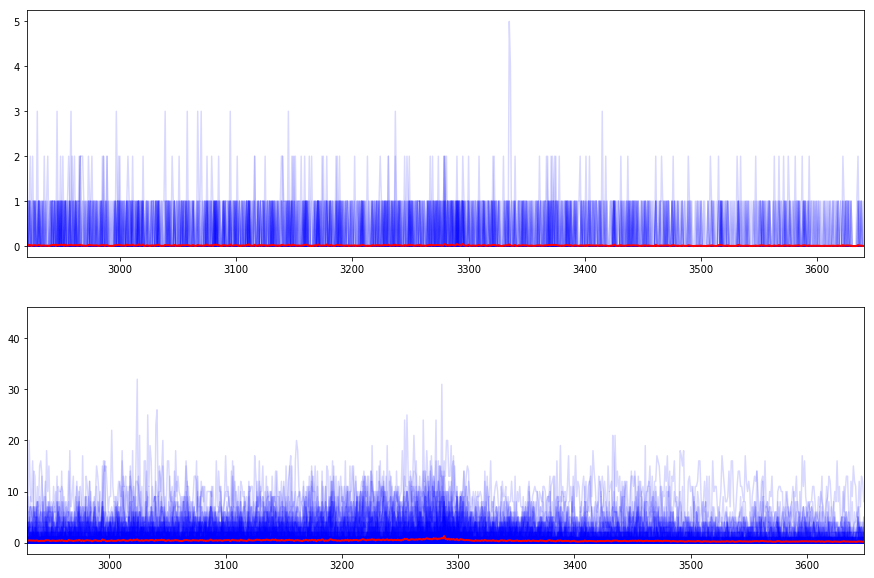

In [137]:
df_min_interaction = df_silver_badge_users.groupby('UserId').agg('max')[['Date']].reset_index()
df_min_interaction.rename(columns={'Date': 'date_of_first_badge'}, inplace=True)
df = pd.merge(df_posts, df_min_interaction, left_on='OwnerUserId', right_on='UserId', how='inner')
df['days'] = df.apply(lambda row: (row.CreationDate - row.date_of_first_badge).days, axis=1)

fig, (ax1,ax2) = plt.subplots(2,1, figsize=(15,10))

_, days_min = plot_interaction_data(df, ax1, post_type_id=1, color='b', alpha=.15)
ax1.set_xlim([days_min-lim, days_min+lim])

_, days_min = plot_interaction_data(df, ax2, post_type_id=2, color='b', alpha=.15)
ax2.set_xlim([days_min-lim, days_min+lim])

plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fba9a8fab70>]],
      dtype=object)

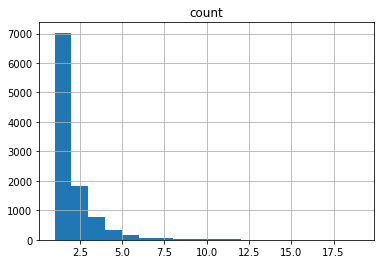

In [143]:
df_silver_badge_users.groupby('UserId').size().reset_index(name='count')[['count']].hist(bins=np.arange(1,20))

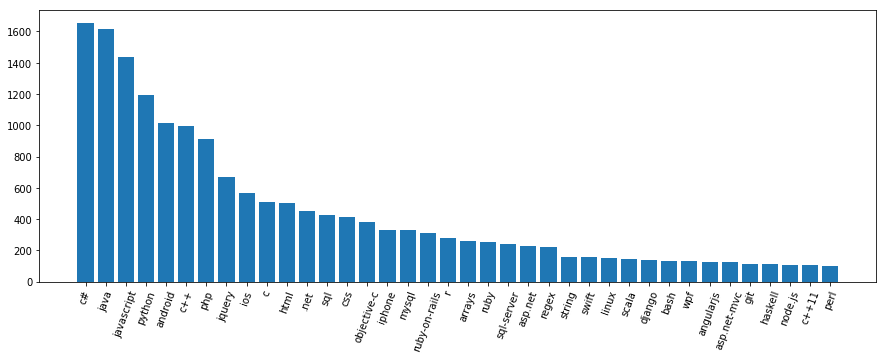

In [152]:
df = df_silver_badge_users.groupby('Name').size().reset_index(name='count')
df.sort_values('count', inplace=True, ascending=False)

plt.figure(figsize=(15,5))
plt.bar(x=df.Name, height=df['count'])
plt.xticks(rotation=70)
plt.show()